# Homework 3
___
### Antonio Castañares Rodríguez, A20599898

### Due date: 09/29/2024
___


Instruction:

- There are 4 problems worth 5 points each.
- Do not clear output when you submit your homework.
- Submit a single `.ipynb` file.
- Make sure everything runs.
- Make sure the output of the last cell for `time_nonvectorized/time_vectorized` exists.
- Nonvectorized time should be at least 2 times  slower than vectorized time.
- Do not `import` anything other than `numpy`, `time` and `matplotlib.pyplot`
- For full credit, do NOT use in your solution the following
  - `for` loops
  - `while` loops
  - list comprehension, i.e., `[.... for ... in ...]`
  - dictionary comprehension, i.e., `{.... for ... in ...}`
  - `map`
  - recursion

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Background

In "standard" binary classification, we have data
$$
x^{(1)}, \dots, x^{(n)} \in \mathbb{R}^d
$$
where each sample is a *single* $d$-dimensional vector (and the labels $y^{(1)},\dots, y^{(n)} \in \{ \pm 1\}$).



In this homework problem, you will consider a setting where each data point is itself a *collection* of $C$ vectors (for concreteness, take $C = 32$), i.e.,
$$
x^{(i)}
=
\{x^{(i,1)}, \dots, x^{(i,C)}  \}  \quad \text{where} \quad x^{(i,c)} \in \mathbb{R}^d \quad \text{for each} \quad c =1,\dots, C
$$

Alternatively, you can also view each $x^{(i)}$ as a matrix whose $c$-th column is $x^{(i,c)}$, i.e.,

$$
X^{(i)}
=
\begin{bmatrix}
x^{(i,1)} & \cdots &
x^{(i,C)}
\end{bmatrix} \in \mathbb{R}^{d \times C} \quad \text{ is a } d \times C \text{ matrix}
$$
(and the labels $y^{(1)},\dots, y^{(n)} \in \{ \pm 1\}$, as before).

In the code, we will name
- $C$ as `n_context`
- $d$ as `n_features`
- $n$ as `n_samples`

In [2]:
n_context = 32
n_features = 3
n_samples = 100

## Load data


In [3]:
X = np.loadtxt("X.csv", delimiter=",").reshape((n_samples, n_context, n_features))
y = np.loadtxt("y.csv", delimiter=",")

## The model

Let $q$ be a positive integer smaller than $d$.
You will consider a model of this form:

Let

$$
\theta = [ W^{(1)}, W^{(2)}, w^{(3)}]
$$

where

$$
W^{(1)} \text{ and }  W^{(2)} \in \mathbb{R}^{q \times d}
$$

$$
 w^{(3)} \in \mathbb{R}^{d}
$$

and

$$
f(X^{(i)} ; \theta)
=
w^{(3) \top}
X^{(i)}
\mathrm{softmax} ( X^{(i)\top} W^{(2)\top } W^{(1)} x^{(i,C)})
$$


In the code, we will name
- $q$ as `n_reduced`


In [4]:
n_reduced = 2

### A single forward pass

Now, let us consider the "forward" function on a single data point

In [5]:
i = 13
Xi, yi = X[i], y[i]

In [6]:
np.random.seed(101)
theta = {'w3':  np.random.randn(n_features),
         'W2': np.random.randn(n_features, n_reduced),
         'W1': np.random.randn(n_features, n_reduced)}
W1, W2, w3 = theta['W1'], theta['W2'], theta['w3']

Let's compute it piece by piece, starting with
$$
f(X^{(i)} ; \theta)
=
w^{(3) \top}
X^{(i)}
\mathrm{softmax} ( X^{(i)\top} W^{(2)\top }
 \underbrace{W^{(1)} x^{(i,C)}}_{\text{this part}})
$$
which we'll call it `query`

In [7]:
query = Xi[-1] @ W1

next
$$
f(X^{(i)} ; \theta)
=
w^{(3) \top}
X^{(i)}
\mathrm{softmax} ( \underbrace{ X^{(i)\top} W^{(2)\top } }_{\text{this part}}
 {W^{(1)} x^{(i,C)}})
$$
which we'll call it `Key`

In [8]:
Key = Xi @ W2

Now,
$$
f(X^{(i)} ; \theta)
=
w^{(3) \top}
X^{(i)}
\underbrace{
\mathrm{softmax} (  X^{(i)\top} W^{(2)\top }
 {W^{(1)} x^{(i,C)}})
 }_{\text{this part}}
$$


In [9]:
expKq = np.exp(Key@query)
softmaxKq = expKq / np.sum(expKq)

Finally, the whole thing:

In [10]:
softmaxKq @ Xi @ w3

np.float64(-1.4416064380452254)

### (Non-vectorized) forward function

In [11]:
def forward_nonvectorized(Xi, theta):
    W1, W2, w3 = theta['W1'], theta['W2'], theta['w3']
    query = Xi[-1] @ W1
    Key = Xi @ W2
    expKq = np.exp(Key@query)
    softmaxKq = expKq / np.sum(expKq) 
    return softmaxKq @ Xi @ w3 

forward_nonvectorized(Xi, theta)

np.float64(-1.4416064380452254)

### Evaluating the (nonvectorized) forward function


We could run the forward function list-wise

In [12]:
np.array([forward_nonvectorized(Xi, theta) for Xi in X][:5])

array([-0.60563255, -0.58440139,  0.3203104 , -0.39511221,  0.89575943])

But it is more efficient if we can run the forward function in "vectorized-mode".

## Loss function

We will use the binary logistic loss

$$
J_i(\theta) := \log(1 + \exp(-y^{(i)} f(X^{(i)} ; \theta)))
$$

So the overall loss/risk is

$$
J(\theta) = \frac{1}{\mathtt{n\_samples} } \sum_{i=1}^{\mathtt{n\_samples}} J_i(\theta)
$$

# [5pts] Problem 1: Vectorize the forward function.


In [13]:
def forward(X, theta):
    W1, W2, w3 = theta['W1'], theta['W2'], theta['w3']
    
    # Compute query and key
    query = X[:, -1, :] @ W1  # shape: (100, 2)
    key = X @ W2  # shape: (100, 32, 1)
    
    # Reshape query for matrix multiplication
    query = query[:, np.newaxis, :]  # shape: (100, 1, 2)
    
    # Compute expKq
    expKq = np.exp(np.matmul(key, query.transpose(0, 2, 1))).squeeze()  # shape: (100, 32)
    
    # Compute softmaxKq
    softmaxKq = expKq / np.sum(expKq, axis=-1, keepdims=True)  # shape: (100, 32)

    return np.matmul(softmaxKq[:, np.newaxis, :], X).squeeze() @ w3 # shape: (100,1,32) @ (100,32,3) = (100,1,3).squeeze = (100,3) @ (3,) = (100,1) 

forward(X,theta)[:5]

array([-0.60563255, -0.58440139,  0.3203104 , -0.39511221,  0.89575943])

# [5pts] Problem 2: Vectorizing `dJdw3`

First, we compute $ \frac{\partial J}{\partial w^{(3)}}(\theta)$. We won't actually work out the math, but the (non-vectorized, i.e., computing $\frac{\partial J_i}{\partial w^{(3)}}(\theta)$ one $i$ at a time then take the mean) code is as follows.

In [14]:
def compute_dJidw3_nonvectorized(Xi, yi, theta):
    W1, W2, w3 = theta['W1'], theta['W2'], theta['w3']
    query = Xi[-1] @ W1
    Key = Xi @ W2
    expKq = np.exp(Key@query)
    softmaxKq = expKq / np.sum(expKq)
    zi = softmaxKq @ Xi @ w3
    return (softmaxKq @ Xi) * (-np.exp(-yi*zi))/(1+np.exp(-yi*zi)) * yi

def compute_dJdw3_nonvectorized(X,y,theta):
    return np.array([compute_dJidw3_nonvectorized(X[i], y[i],theta) for i in range(n_samples)]).mean(axis=0)
compute_dJdw3_nonvectorized(X,y,theta)


array([ 0.12614065, -0.10058033, -0.27192813])

In [15]:
def compute_dJdw3(X, y, theta):
    W1, W2, w3 = theta['W1'], theta['W2'], theta['w3']
    
    # Compute query and key
    query = X[:, -1, :] @ W1  # shape: (100, 2)
    key = X @ W2  # shape: (100, 32, 1)
    
    # Reshape query for matrix multiplication
    query = query[:, np.newaxis, :]  # shape: (100, 1, 2)
    
    # Compute expKq
    expKq = np.exp(np.matmul(key, query.transpose(0, 2, 1))).squeeze()  # shape: (100, 32)
    
    # Compute softmaxKq
    softmaxKq = expKq / np.sum(expKq, axis=-1, keepdims=True)  # shape: (100, 32)
    
    # Compute result
    z1 = np.matmul(softmaxKq[:, np.newaxis, :], X).squeeze() @ w3  # shape: (100, 1)

    # Compute the loss_der
    operation1 = np.matmul(softmaxKq[:, np.newaxis, :], X).squeeze()  # shape: (100, 3)
    operation2 = operation1 * (-np.exp(-y * z1))[:, np.newaxis] # shape: (100, 3)
    operation3 = operation2 / (1 + np.exp(-y * z1))[:, np.newaxis]  # shape: (100, 3)
    loss_der = operation3 * y[:, np.newaxis]  # shape: (100, 3)

    return loss_der.mean(axis=0)

compute_dJdw3(X,y,theta)

array([ 0.12614065, -0.10058033, -0.27192813])

# [5pts] Problem 3: Vectorizing `dJdW2`

Next, we compute $ \frac{\partial J}{\partial W^{(2)}}(\theta)$. We won't actually work out the math, but the (non-vectorized) code is as follows.

In [16]:
dJdW2 = np.zeros(W2.shape)

def compute_dJidW2_nonvectorized(Xi, yi, theta):
    W1, W2, w3 = theta['W1'], theta['W2'], theta['w3']
    query = Xi[-1] @ W1
    Key = Xi @ W2
    expKq = np.exp(Key@query)
    softmaxKq = expKq / np.sum(expKq)
    delSoftmax =  np.diag(softmaxKq)-np.outer(softmaxKq,softmaxKq)

    zi = softmaxKq @ Xi @ w3
    loss_der = (-np.exp(-yi*zi))/(1+np.exp(-yi*zi)) * yi

    return np.outer((Xi.T@delSoftmax) @ (Xi@w3), W1.T@Xi[-1])*loss_der

def compute_dJdW2_nonvectorized(X,y,theta):
    dJdW2 = np.zeros(W2.shape)
    for i in range(n_samples):
        dJdW2 += compute_dJidW2_nonvectorized(X[i], y[i],theta)
    return dJdW2/n_samples
compute_dJdW2_nonvectorized(X,y,theta)

array([[0.16829444, 0.20709899],
       [0.10940378, 0.11681514],
       [0.02592543, 0.0226713 ]])

In [17]:
def compute_dJdW2(Xi, yi, theta):
    W1, W2, w3 = theta['W1'], theta['W2'], theta['w3']
    
    # Compute query and key
    query = X[:, -1, :] @ W1  # shape: (100, 2)
    key = X @ W2  # shape: (100, 32, 1)
    
    # Reshape query for matrix multiplication
    query = query[:, np.newaxis, :]  # shape: (100, 1, 2)
    
    # Compute expKq
    expKq = np.exp(np.matmul(key, query.transpose(0, 2, 1))).squeeze()  # shape: (100, 32)
    
    # Compute softmaxKq
    softmaxKq = expKq / np.sum(expKq, axis=-1, keepdims=True)  # shape: (100, 32)
    
    # Compute the diagonal part
    diag_part = softmaxKq[:, :, np.newaxis] * np.eye(softmaxKq.shape[1])  # shape: (100, 32, 32)

    # Compute the outer product part
    outer_part = softmaxKq[:, :, np.newaxis] * softmaxKq[:, np.newaxis, :]  # shape: (100, 32, 32)

    # Compute delSoftmax
    delSoftmax = diag_part - outer_part  # shape: (100, 32, 32)

    # Compute result
    z1 = np.matmul(softmaxKq[:, np.newaxis, :], X).squeeze() @ w3  # shape: (100, 1)

    # Compute the loss_der
    operation1 = (-np.exp(-y * z1))[:, np.newaxis] # shape: (100, 3)
    operation2 = operation1 / (1 + np.exp(-y * z1))[:, np.newaxis]  # shape: (100, 3)
    loss_der = (operation2.T * y).T # shape: (100, 3)
    
    # Compute the arguments of np.outer
    first_argument = np.matmul(X.transpose(0, 2, 1), delSoftmax)  # shape: (100, 3, 32)
    second_argument = np.matmul(X, w3)[:, np.newaxis, :]  # shape: (100, 1, 32)
    third_argument = np.matmul(W1.T, X[:, -1, :].T).T  # shape: (100, 2)

    # Compute the outer product
    part1 = np.matmul(first_argument,second_argument.transpose(0,2,1))  # shape(100,3,1)
    outer = np.matmul(part1,third_argument[:, np.newaxis, :])  # shape(100,3,2)

    return np.mean(outer * loss_der[:,:,np.newaxis],axis=0)

compute_dJdW2(X,y,theta)

array([[0.16829444, 0.20709899],
       [0.10940378, 0.11681514],
       [0.02592543, 0.0226713 ]])

# [5pts] Problem 4: Vectorizing `dJdW1`

Finally, we compute $ \frac{\partial J}{\partial W^{(1)}}(\theta)$. We won't actually work out the math, but the (non-vectorized) code is as follows.

In [18]:
def compute_dJidW1_nonvectorized(Xi, yi, theta):
    W1, W2, w3 = theta['W1'], theta['W2'], theta['w3']
    query = Xi[-1] @ W1
    Key = Xi @ W2
    expKq = np.exp(Key@query)
    softmaxKq = expKq / np.sum(expKq)
    delSoftmax =  np.diag(softmaxKq)-np.outer(softmaxKq,softmaxKq)

    zi = softmaxKq @ Xi @ w3
    loss_der = (-np.exp(-yi*zi))/(1+np.exp(-yi*zi)) * yi
    return np.outer(((Xi@W2).T@delSoftmax) @ (Xi@w3), Xi[-1]).T*loss_der


def compute_dJdW1_nonvectorized(X,y,theta):
    dJdW1 = np.zeros(W2.shape)
    for i in range(n_samples):
        dJdW1 += compute_dJidW1_nonvectorized(X[i], y[i],theta)
    return dJdW1/n_samples

compute_dJdW1_nonvectorized(X,y,theta)

array([[-0.02485981,  0.03648229],
       [-0.01022258,  0.05216037],
       [-0.10271108,  0.04190961]])

In [19]:
def compute_dJdW1(Xi, yi, theta):
    W1, W2, w3 = theta['W1'], theta['W2'], theta['w3']
    
    # Compute query and key
    query = X[:, -1, :] @ W1  # shape: (100, 2)
    key = X @ W2  # shape: (100, 32, 1)
    
    # Reshape query for matrix multiplication
    query = query[:, np.newaxis, :]  # shape: (100, 1, 2)
    
    # Compute expKq
    expKq = np.exp(np.matmul(key, query.transpose(0, 2, 1))).squeeze()  # shape: (100, 32)
    
    # Compute softmaxKq
    softmaxKq = expKq / np.sum(expKq, axis=-1, keepdims=True)  # shape: (100, 32)

    # Compute the diagonal part
    diag_part = softmaxKq[:, :, np.newaxis] * np.eye(softmaxKq.shape[1])  # shape: (100, 32, 32)

    # Compute the outer product part
    outer_part = softmaxKq[:, :, np.newaxis] * softmaxKq[:, np.newaxis, :]  # shape: (100, 32, 32)

    # Compute delSoftmax
    delSoftmax = diag_part - outer_part  # shape: (100, 32, 32)

    # Compute z1
    z1 = np.matmul(softmaxKq[:, np.newaxis, :], X).squeeze() @ w3  # shape: (100, 1)

    # Compute the loss_der
    operation1 = (-np.exp(-y * z1))[:, np.newaxis] # shape: (100, 3)
    operation2 = operation1 / (1 + np.exp(-y * z1))[:, np.newaxis]  # shape: (100, 3)
    loss_der = (operation2.T * y).T # shape: (100, 3)

    # Compute the arguments of np.outer
    first_argument = (X @ W2).transpose(0, 2, 1) @ delSoftmax  
    second_argument = X @w3
    part1 = np.matmul(first_argument,second_argument[:,:,np.newaxis]) 
    third_argument = X[:, -1, :] 
    outer = np.matmul(part1,third_argument[:, np.newaxis, :]) 

    return np.mean(outer * loss_der[:,:,np.newaxis],axis=0).T

compute_dJdW1(X,y,theta)

array([[-0.02485981,  0.03648229],
       [-0.01022258,  0.05216037],
       [-0.10271108,  0.04190961]])

# (Not graded) Time comparison



In [20]:
np.random.seed(100)
theta = {'w3':  np.random.randn(n_features),
         'W2': np.random.randn(n_features, n_reduced),
         'W1': np.random.randn(n_features, n_reduced)}

error_list = []

start_timer = time.time()
for i in range(1000):
    dJdw3 = compute_dJdw3(X,y,theta)
    dJdW2 = compute_dJdW2(X,y,theta)
    dJdW1 = compute_dJdW1(X,y,theta)

    theta['w3'] -= 0.1*dJdw3
    theta['W2'] -= 0.1*dJdW2
    theta['W1'] -= 0.1*dJdW1
    error = np.mean(np.sign(forward(X,theta))*y<=0.0)
    error_list.append(error)
stop_timer = time.time()
time_vectorized = stop_timer-start_timer
print(f"Time taken: {stop_timer-start_timer}")

Time taken: 2.834155559539795


Text(0, 0.5, 'error (misclassification)')

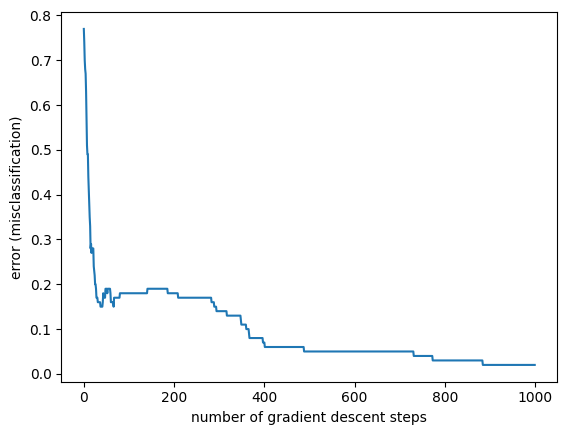

In [21]:

plt.plot(error_list)
plt.xlabel('number of gradient descent steps')
plt.ylabel('error (misclassification)')

In [22]:
np.random.seed(100)
theta = {'w3':  np.random.randn(n_features),
         'W2': np.random.randn(n_features, n_reduced),
         'W1': np.random.randn(n_features, n_reduced)}

error_list = []

start_timer = time.time()
for i in range(1000):
    dJdw3 = compute_dJdw3_nonvectorized(X,y,theta)
    dJdW2 = compute_dJdW2_nonvectorized(X,y,theta)
    dJdW1 = compute_dJdW1_nonvectorized(X,y,theta)

    theta['w3'] -= 0.1*dJdw3
    theta['W2'] -= 0.1*dJdW2
    theta['W1'] -= 0.1*dJdW1
    error = np.mean(np.sign(forward(X,theta))*y<=0.0)
    error_list.append(error)
stop_timer = time.time()
time_nonvectorized = stop_timer-start_timer
print(f"Time taken: {stop_timer-start_timer}")

Time taken: 11.108343601226807


Text(0, 0.5, 'error (misclassification)')

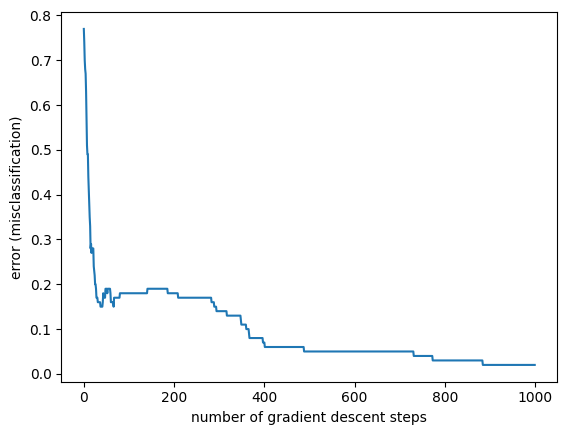

In [23]:

plt.plot(error_list)
plt.xlabel('number of gradient descent steps')
plt.ylabel('error (misclassification)')

In [24]:
time_nonvectorized/time_vectorized

3.919454443435899